**BEFORE RUNNING THIS CODE**
1. Make sure you have the helper.py and PneumoniaModel.pt file in the same folder as this code
2. The folder contains the test, train and val folders with the corresponding images of the Pneumonia dataset that can be found at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt #To visualize the data
from PIL import Image  # To load image data to Python
#import scipy.ndimage as nd #To perform preprosssing on image data 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import transforms as T, datasets
from helper import view_classify, show_image, show_grid, accuracy
import torch.nn.functional as F
import timm
from torchsummary import summary


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Making the 1st Class Called Configuration 
class CFG:
    
    epochs = 5  # No. of epochs of training the model -- We are going to run this EPOCH during the training Loop -- how many time we are going to run the training lopp!
    lr = 0.001    # Learning rate -- 
    batch_size = 10                               # Batch Size For Dataset #number of samples thta give simustaneusly 
    
    model_name = 'tf_efficientnet_b4_ns'               # Model name (We are going to import model from timm)

    img_size = 224
    
    # Going to be use for loading dataset 
    DATA_DIR = ""                       # Data Directory 
    TEST = 'test'                                      # Test folder name in data directory 
    TRAIN = 'train'                                    # Train folder name in data directory 
    VAL ='val'                                         # Valid folder name in data directory 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # we are gonna use CPU
    
print("On which device we are on : {}".format(device))

On which device we are on : cpu


**Explanation of Class Configuration**
Epoch:  The more epoch it has the more effectively train will. Training for more epochs allows the network to learn more patterns and improve its performance over time
lr: Hyper Parameter that controls how quickly or slow learns:  models parameter or Weights are updated during the training process
batch_size: # of training samples in a single batch  ...  1 epoch =  many batches 
model_name : ??? 
img_size: genetic for all  224


In [3]:
# TRANSFORMING THE DATA 
train_transform = T.Compose([
            
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.RandomRotation(degrees = (-20,+20)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) # Tranform PIL (0,255) image to Tensor CxHxW, [mean] + [standard deviation]
])

valid_transform = T.Compose([
    
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [4]:

import os 
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path,transform = train_transform)
validset = datasets.ImageFolder(valid_path,transform = valid_transform)
testset = datasets.ImageFolder(test_path,transform = test_transform)

print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))
total = len(trainset)+len(validset)+len(testset)
print("Total :",total)

Trainset Size : 5216
Validset Size : 16
Testset Size : 624
Total : 5856


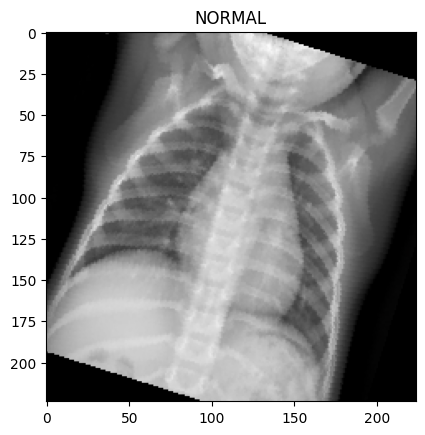

In [5]:
image, label = trainset[2]

class_names = ['NORMAL','PNEUMONIA']

show_image(image,class_names[label])

    

In [6]:
# Load Data Set into Batches #
trainloader = DataLoader(trainset, batch_size = CFG.batch_size , shuffle = True)
validloader = DataLoader(validset, batch_size = CFG.batch_size , shuffle = True)
testloader = DataLoader(testset, batch_size = CFG.batch_size , shuffle = True)

print("Number of batches in Train Loader : {}".format(len(trainloader)))
print("Number of batches in Train Loader : {}".format(len(validloader)))
print("Number of batches in Train Loader : {}".format(len(testloader)))
print("Number of Total samples : {}".format(len(trainloader.dataset)))

Number of batches in Train Loader : 522
Number of batches in Train Loader : 2
Number of batches in Train Loader : 63
Number of Total samples : 5216


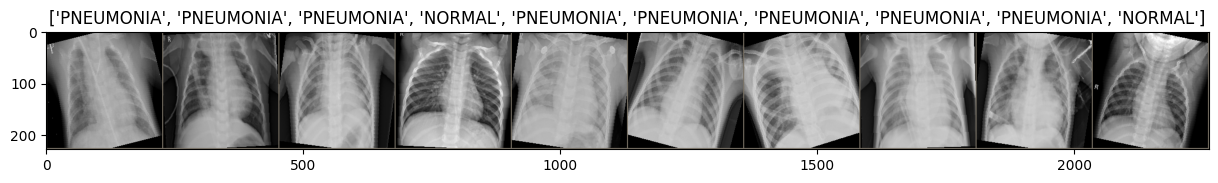

In [7]:
dataiter = iter(trainloader) # create an iterator : every time we make  aprediction // every time the network weights are updated
images, labels = next(dataiter)

out = make_grid(images,nrow=16)

show_grid(out, title=[class_names[x] for x in labels])

Fine Tuning and **EFFICIENT NET MODEL**
updating last layer as classifier  > linear layer that takes 1792 features in and 1000 claasses in the imagenet (out)
Read summary 



In [8]:
#creating a sequential model / used to compute the output of each neuron
model = timm.create_model(CFG.model_name,pretrained = True)

for param in model.parameters():
    param.requires_grad = False #freezing the part of the model as no changes happen to its parameters

# modifies the classifier part of the model's architecture. It replaces the existing classifier 
# with a new sequence of layers defined within the nn.Sequential() container. 
model.classifier = nn.Sequential(

#multiclass Classification 
        nn.Linear(in_features = 1792, out_features = 625),
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(in_features = 625, out_features = 246),
        nn.ReLU(), #Activation Layer
        nn.Linear(in_features = 246, out_features = 2) #use only cross entropy loss / softmax layer
        
)

model.to(device) # only for GPU


#summary (model, input_size = (3,224,224))

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

**Building a Trainer** 
Cross-entropy loss : SOFT max function ... loss function in PyTorch for training classification models : measures the difference between the **predicted class probabilities** and the **true class lables** 

In [9]:
# Buildidng a Trainer 

class PneumoniaTrainer():
    
    def __init__(self,criterion = None, optimizer = None,schedular = None):
        
        self.criterion = criterion # loss funtion 
        self.optimizer = optimizer # adjust the parameters in order to minimize the loss function 
        self.schedular = schedular # adjusting the learning rate during the training process
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader):
            
            images = images.to(device) #Pass images and labels to be processed either in the CPU or GPU
            labels = labels.to(device)
            
            logits = model(images) # use the pytorch  cross entropy loss
            loss = self.criterion(logits,labels) 
            
            self.optimizer.zero_grad() #gradient = 0
            loss.backward()
            self.optimizer.step() # All optimizers implement a step() method, that updates the parameters.
            
            train_loss += loss.item() # Cumulative training phase loss
            train_acc += accuracy(logits,labels) # Cumulative training phase accuracy
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader): 
        '''
    This function is basically the same as train_batch_loop
    Just for the validation loader and images
    '''
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            images = images.to(device) #Pass images and labels to be processed either in the CPU or GPU
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        '''
        This function calls both train_batch_loop and valid_batch_loop
        for each epoch. 
        '''
        all_train_losses=[]
        all_valid_losses=[]

        all_train_accs=[]
        all_valid_accs=[]
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader)
            
            model.eval()
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader)
            
            if avg_valid_loss <= valid_min_loss : 
                ''' 
                We gonna select the model where the loss is minimal
                and return said model for furhter testing
                '''
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'PneumoniaModel.pt')
                valid_min_loss = avg_valid_loss

            all_train_losses.append(avg_train_loss)
            all_valid_losses.append(avg_valid_loss)

            all_train_accs.append(avg_train_acc)
            all_valid_accs.append(avg_valid_acc)

        
                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

        return all_train_losses, all_valid_losses, all_train_accs, all_valid_accs


**LET'S TRAIN**

In [10]:
#Training the model

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = PneumoniaTrainer(criterion,optimizer)
atl,avl,ata,ava=trainer.fit(model,trainloader,validloader,epochs = CFG.epochs)

  0%|          | 0/522 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


Valid_loss decreased inf --> 0.7660863101482391
Epoch : 1 Train Loss : 0.264872 Train Acc : 0.892718
Epoch : 1 Valid Loss : 0.766086 Valid Acc : 0.533333


100%|██████████| 2/2 [00:04<00:00,  2.48s/it]


Epoch : 2 Train Loss : 0.224147 Train Acc : 0.906767
Epoch : 2 Valid Loss : 0.849743 Valid Acc : 0.416667


100%|██████████| 2/2 [00:05<00:00,  2.50s/it]


Valid_loss decreased 0.7660863101482391 --> 0.7523041665554047
Epoch : 3 Train Loss : 0.213220 Train Acc : 0.915707
Epoch : 3 Valid Loss : 0.752304 Valid Acc : 0.516667


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Valid_loss decreased 0.7523041665554047 --> 0.5612483769655228
Epoch : 4 Train Loss : 0.202274 Train Acc : 0.919538
Epoch : 4 Valid Loss : 0.561248 Valid Acc : 0.816667


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]

Epoch : 5 Train Loss : 0.188399 Train Acc : 0.924710
Epoch : 5 Valid Loss : 0.640569 Valid Acc : 0.666667


**WE PLOT LOSS AND ACCURACY FOR TRAINING AND VALIDATION PHASES**

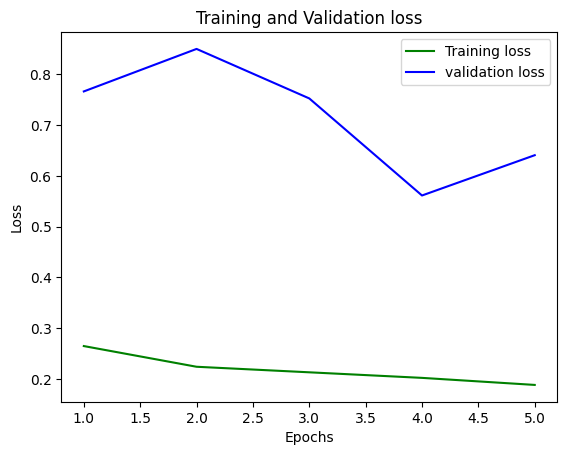

In [13]:
epochs = range(1,CFG.epochs+1)
plt.plot(epochs, atl, 'g', label='Training loss')
plt.plot(epochs, avl, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

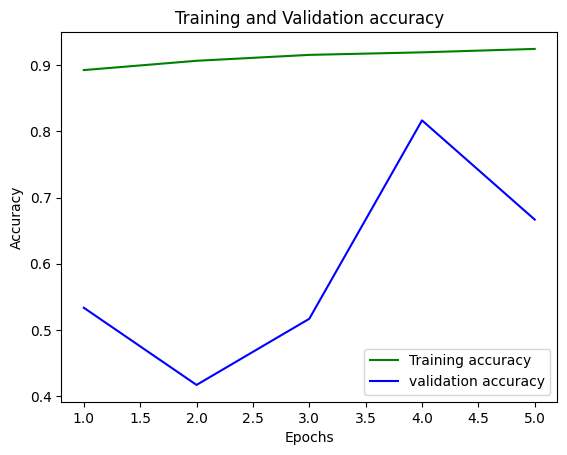

In [14]:
epochs = range(1,CFG.epochs+1)
plt.plot(epochs, ata, 'g', label='Training accuracy')
plt.plot(epochs, ava, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**TESTING TESTING 1,2 1,2!!**

In [15]:
#Plot Results 

model.load_state_dict(torch.load('PneumoniaModel.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

100%|██████████| 63/63 [02:02<00:00,  1.94s/it]

Test Loss : 0.3043714878814561
Test Acc : 0.8730159997940063


**WE SELECT A RANDOM IMAGE, SEE IT'S GROUND TRUTH AND WHAT OUR SELECTED MODEL HAS TO SAY ABOUT IT**

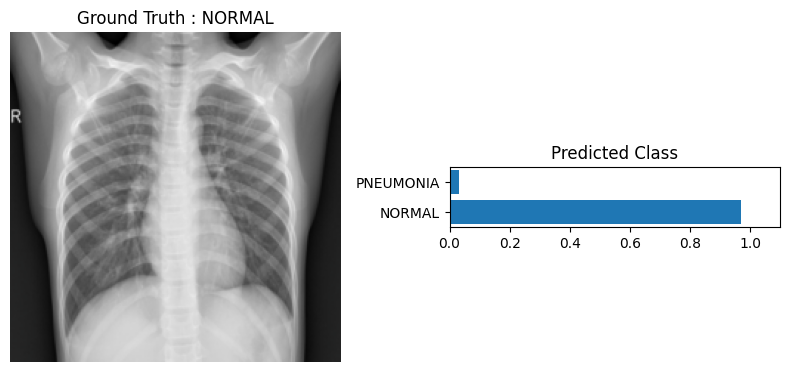

In [21]:

image,label = testset[55]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)